# Practical 4 - Dimensionality Reduction and Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context='talk',style='white',palette='colorblind')
import pandas
import pickle
import scipy
import matplotlib
from scipy import sparse
import sklearn
import sklearn.mixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import scipy as sp
import copy

## Task 0: Load and normalize count data

This practical uses the data set from https://www.nature.com/articles/s41586-018-0654-5. This is single cell transcriptomics data from ~25,000 cells from the cortex. 

For each of these cells, the expression of several thousand genes was measured ```['counts']```. In the original study, the authors were interested in clustering the cells into types. 

We made a selection of 5000 cells and the 1000 most informative genes for run time reasons. We provide you with the original cell type labels determined by the authors for comparison ```['clusters']```.

The following function will apply some preprocessing steps that are standard for transcriptomics data.

In [2]:
def lognormalize_counts(tasic_dict):
    
    #normalize and logtransform counts
    counts = tasic_dict['counts']
    libsizes = counts.sum(axis=1)
    CPM = counts / libsizes * 1e+6
    logCPM = np.log2(CPM + 1) 
    tasic_dict['logCPM'] = np.array(logCPM)  
    
    return tasic_dict

In [3]:
tasic_1k = lognormalize_counts(
    pickle.load(open('data/tasic_subset_1kselected.pickle', 'rb')))

print("Counts:   " + str(tasic_1k['counts'].shape))
print("LogPCM:   " + str(tasic_1k['logCPM'].shape))
print("Clusters: " + str(tasic_1k['clusters'].shape))

Counts:   (5000, 1000)
LogPCM:   (5000, 1000)
Clusters: (5000,)


Have a look at ```['counts']```, ```['logPCM']``` and ```['clusters']``` to get a better understanding of the data.

## Task 1: Linear dimensionality reduction with PCA

In this task, you will use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset.

First, implement PCA "by hand". You can use eigenvalue/singular value decomposition from numpy/scipy but no `sklearn`-functions. Write a function that computes all possible principal components and returns them along with the fraction of variance they explain.

In [76]:
def PCA_manual(_data):
    '''
    Function that performs PCA on the input data
    
    input: (cells, genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes, genes)-shaped array containing the principal components as columns
    '''
    ### NOTE: Make sure the function returns the PCs sorted by the fraction of variance explained! ###
    ###       (First column of principal_components should hold the PC with the highest variance   ###
    ###       explained -- fraction_variance_explained should also be sorted accordingly)          ###

    # ---------------- INSERT CODE ----------------------
    
    # Step 1: Centering. Setting column (gene) mean to zero.
    data = copy.deepcopy(_data)
    centered = data - np.mean(data.T, axis=1)
    # Manual:
    #centered = data
    #l = centered.shape[1]
    #assert l == 1000
    #m = centered.shape[0]
    #assert m == 5000
    
    #for i in range(l):
    #    val = 0
    #    for j in range(m):
    #        val += centered[j][i]
    #    val /= m
    #    for j in range(m):
    #        centered[j][i] -= val
    
    print(np.mean(centered, axis=0).shape)
    
    
    # Step 2: Covariance matrix
    C = np.cov(centered.T)
    
    # Step 3: Eigenvalue decomposition
    values, vectors = np.linalg.eig(C)
    
    # Step 4: Sort the values and vectors decending (argsort sorts ascending)
    idx = np.argsort(values)[::-1]
    
    # Step 5: Return (eigenvalues are 'fraction_variance_explained', eigenvectors are 'principal_components')
    principal_components = vectors[idx].T
    fraction_variance_explained = values[idx]   
        
    # Checkpoint.
    print(C - vectors.dot(np.diag(values)).dot(vectors.T))
    
    
    
    # Experiments !!!!!!!!!
    # Not for submission
    #print("Shape: ", data.shape)
    
    # Find S (S = 1/N * X^T * X)
    #S = (1 / data.shape[0]) * np.dot(data.T, data)
    #print("Shape: ", S.shape)
    
    # Find eigenvalues and eigenvectors
    #eigenvalues, eigenvectors = np.linalg.eig(S)
    
    #print("VALUES: ", eigenvalues.shape)
    #print("VECTORS: ", eigenvectors.shape)
    
    #a1 = S.dot(eigenvectors[0])
    #a2 = eigenvalues[0] * eigenvectors[0]
    
    #print(a1, a2)
    
    #from sklearn.preprocessing import StandardScaler
    
    # Sklearn
    #pca = PCA()
    #res = pca.fit_transform(data)
    #print("RES: ", res)
    
    # Numpy
    #centered = data - data.mean(axis=0)
    #cov = np.cov(centered)
    #eig, ev = np.linalg.eigh(cov)
    
    #idx = np.argsort(eig)[::-1]
    #ev = ev[:, idx]
    #eig = eig[idx]
    
    
    #a = ev.dot(data).T
    #print("A: ", a)
    
    
    
    # ---------------- END CODE -------------------------

    
    return fraction_variance_explained, principal_components


In [77]:
var_expl, PCs = PCA_manual(tasic_1k['logCPM'])

(1000,)
[[-7.86037901e-14  1.60427227e-14  1.71807013e-14 ...  4.74446871e-15
   2.76480228e-14 -3.58602037e-14]
 [ 1.60427227e-14 -3.14748227e-14  3.08225667e-14 ... -5.27876354e-15
   1.98472152e-14  2.53685961e-14]
 [ 1.71807013e-14  3.08295056e-14  4.49640325e-15 ... -2.52714516e-14
  -7.57727214e-15  8.49320614e-15]
 ...
 [ 4.74446871e-15 -5.27529409e-15 -2.52922683e-14 ... -9.88098492e-15
  -5.15429713e-15  5.66213743e-15]
 [ 2.76445533e-14  1.98487331e-14 -7.57727214e-15 ... -5.15689921e-15
   7.77156117e-15 -1.60982339e-14]
 [-3.58602037e-14  2.53685961e-14  8.49320614e-15 ...  5.77315973e-15
  -1.59872116e-14 -7.99360578e-15]]


Before we explore the structure of the low-dimensional representation, we first want to know how much variance the first PCs explain: 

- Plot the fraction of variance explained by the `n`-th PC vs. `n`

- Plot the cumulative fraction of variance explained by the first `n` PCs with largest eigenvalue vs. `n`

From the latter plot you should be able to see how many PCs you need to keep to explain at least `x`% of the variance.

How many components do you need to keep to explain 50%, 75%, 90% and 99%, respectively? Indicate this in your plot.

To explain 50% of the variance, you would need the first   5 principal components
To explain 75% of the variance, you would need the first  43 principal components
To explain 90% of the variance, you would need the first 193 principal components
To explain 99% of the variance, you would need the first 590 principal components


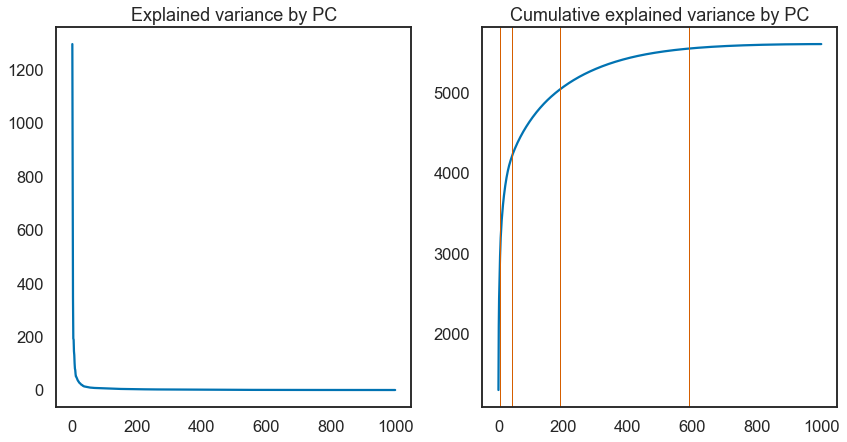

In [78]:
plt.figure(figsize=(14,7))

plt.subplot(121)

# Plot the variance explained of the n-th PC vs. n
# ---------------- INSERT CODE ----------------------

X = np.arange(len(PCs))
Y = var_expl[X]

plt.plot(X, Y)
plt.title("Explained variance by PC")
    
# ---------------- END CODE -------------------------


plt.subplot(122)

# Plot the cumulative variance explained for the n PCs with highest variance explained vs. n
# Indicate how many components you need to keep to explain 50%, 75%, 90% and 99% in the plot.
# ---------------- INSERT CODE ----------------------

X = np.arange(len(PCs))
Y = np.cumsum(var_expl[X])

plt.plot(X, Y)
plt.title("Cumulative explained variance by PC")

total = Y[-1]
above50 = np.flatnonzero(Y > 0.5  * total)[0]
above75 = np.flatnonzero(Y > 0.75 * total)[0]
above90 = np.flatnonzero(Y > 0.9  * total)[0]
above99 = np.flatnonzero(Y > 0.99 * total)[0]

plt.axvline(above50, linewidth=1, color='r', label='50%')
plt.axvline(above75, linewidth=1, color='r', label='75%')
plt.axvline(above90, linewidth=1, color='r', label='90%')
plt.axvline(above99, linewidth=1, color='r', label='99%')

print("To explain 50% of the variance, you would need the first {:>3} principal components".format(above50 + 1))
print("To explain 75% of the variance, you would need the first {:>3} principal components".format(above75 + 1))
print("To explain 90% of the variance, you would need the first {:>3} principal components".format(above90 + 1))
print("To explain 99% of the variance, you would need the first {:>3} principal components".format(above99 + 1))


# ---------------- END CODE -------------------------

YOUR ANSWER HERE

Write a function to select the `n` PCs needed to explain at least `x`% of the variance and use this function to extract as many PCs as are needed to explain 75% of the variance. 

In [79]:
def select_PCs(variance_explained, principal_components, percent_variance=None):
    '''Function that selects the first n principal components necessary to explain x% of the variance
    input: 
        variance_explained: amount of variance explained by the individual PCs
        principal_components: contains the principal components as columns
        percent_variance: fraction of the variance, the all PCs that are kept explain
    output:
        variance_explained_kept: individual amount of variance explained for the remaining PCs
        principal_components_kept: remaining principal components, shape (genes,n_PCs_kept)
                
    '''
  
    # ---------------- INSERT CODE ----------------------
    # Safety net
    if(percent_variance is None):
        percent_variance = 0.75
            
    X = np.arange(len(principal_components))
    Y = np.cumsum(variance_explained[X])
    
    total = Y[-1]
    split = np.flatnonzero(Y > percent_variance  * total)[0]
    
    variance_explained_kept = variance_explained[0:split+1] # +1 because 'at least'
    principal_components_kept = principal_components[0:split+1]
    
    # ---------------- END CODE -------------------------
            
    return variance_explained_kept, principal_components_kept

In [80]:
_, PCs75 = select_PCs(var_expl, PCs, percent_variance=0.75)

To compute the representation of the data in this lower dimensional representation, write a function that compute the PC scores for each cell, i.e. that projects the original data matrix on the low-dimensional subspace provided by the first `n` PCs:

In [81]:
def compute_PCA_scores(data, principal_components):
    '''Function that returns the PC scores for each data point
    input: 
        data                 --- (cells,genes)-shaped array of log transformed cell counts
        principal_components --- contains the principal components as columns\
    output:
        pc_scores            --- (cells,n_PCs_kept)-shaped array of PC scores
    
    ''' 
    
    # ---------------- INSERT CODE ----------------------

    pc_scores = principal_components.dot(data.T).T
    
    # ---------------- END CODE -------------------------

    return pc_scores

In [82]:
tasic_1k['PCA_75'] = compute_PCA_scores(tasic_1k['logCPM'], PCs75)

Visualize the top 5 PCs as a pairwise scatterplot. Use one subplot for each pair of components.

Use the colors provided in `tasic_1k['clusterColors']` and the cluster information in `tasic_1k['clusters']` to color each data point according to its original cluster identity.

If you're familiar with Pandas dataframes and seaborn, this plot can be generated easily. Alternatively you can also do it "by hand" using matplotlib.

The colors indicate the family of the cell type:

- greenish colors: excitatory neurons
- orange colors: somatostatin positive interneurons
- pinkish colors: VIP-postive interneurons
- reddish colors: parvalbumin positive interneurons
- dark colors: non-neurons (glia etc)

What do you observe?

In [83]:
def plot_PCs(data_transformed, color_per_datapoint):
    '''Function that plots the scores of the 10 pairs of the top 5 PCs against each other.
        inputs:
            data_transformed    -- (cells,n_PCs_kept)-shaped array of PC scores
            color_per_datapoint -- (cells,)-shaped array of color strings, one color for each cell
    '''
   
    
    # ---------------- INSERT CODE ----------------------
    
    x = data_transformed[:, :5]
    colors = dict(zip(color_per_datapoint, color_per_datapoint))
    
    df = pandas.DataFrame(x)
    df.insert(5, 'color', color_per_datapoint, True)
    
    g = sns.pairplot(df, hue='color', palette=colors)
    g._legend.remove()
    #sns.pairplot(df)
    
    # ---------------- END CODE -------------------------

c:\frameworks\python\python38\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\frameworks\python\python38\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\frameworks\python\python38\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\frameworks\python\python38\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\frameworks\python\python38\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\frameworks\python\python38\lib\site-packages\seaborn\distribut

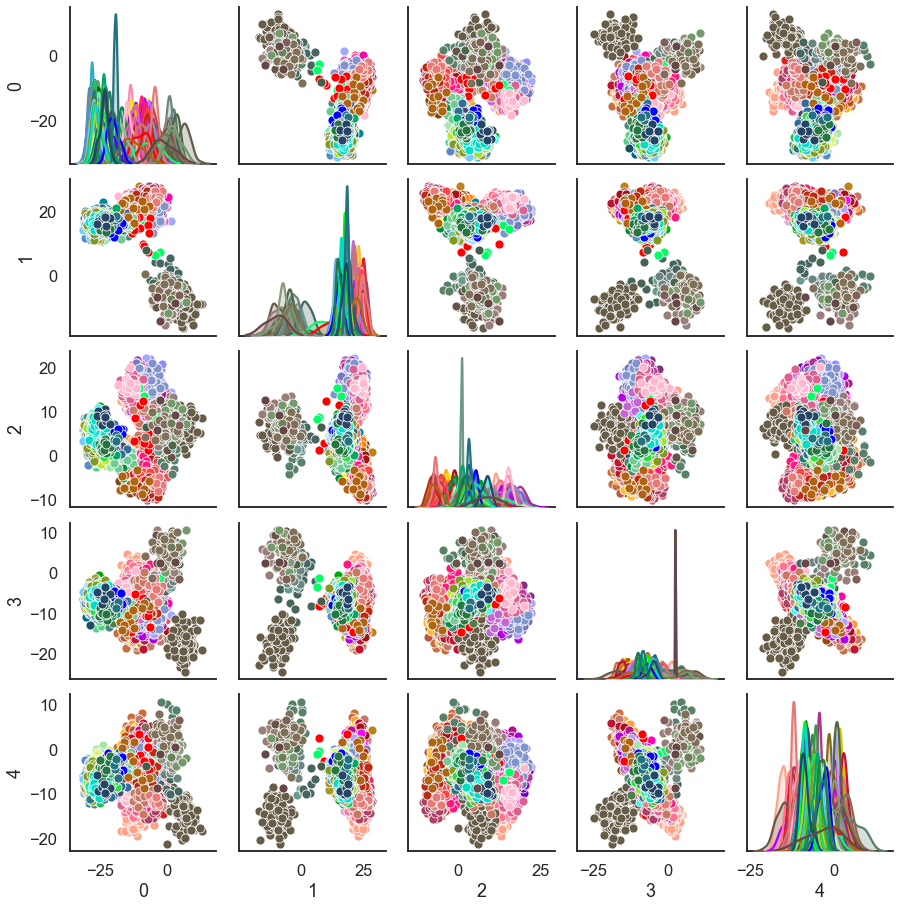

In [84]:
color_per_datapoint = tasic_1k['clusterColors'][tasic_1k['clusters']]
plot_PCs(tasic_1k['PCA_75'], color_per_datapoint)

YOUR ANSWER HERE

## Task 2: Comparison with PCA implemented by sklearn

Use the PCA implementation of sklearn to check whether your PCA implementation is correct and obtain some insights into numerical precision of the algorithms underlying PCA implementations.

In [73]:
def PCA_sklearn(data):
    '''
    Function that performs PCA on the input data, using sklearn
    
    input: (cells,genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes,genes)-shaped array containing the principal components as columns
    '''

    # ---------------- INSERT CODE ----------------------
    pca = PCA().fit(data)
    fraction_variance_explained = pca.explained_variance_
    principal_components = pca.components_    
    
    # ---------------- END CODE -------------------------
    
    return fraction_variance_explained, principal_components

In [74]:
#do sklearn-PCA on selected genes
var_expl_sklearn, PCs_sklearn = PCA_sklearn(tasic_1k['logCPM'])
#select components as before
_, PCs_sklearn75 = select_PCs(var_expl_sklearn, PCs_sklearn, 0.75)
#get PC scores
PCA_75_sklearn = compute_PCA_scores(tasic_1k['logCPM'], PCs_sklearn75)

To see if your manual PCA yielded the same PC weights as the sklearn PCA, we can just take the two matrices of principal components and plot their entries against each other. (Note: This again assumes they are sorted by variance explained..)

Use the following plot to compare the results to your own implementation (here plotting the weights of the first 100 PCs against each other). What do you observe?

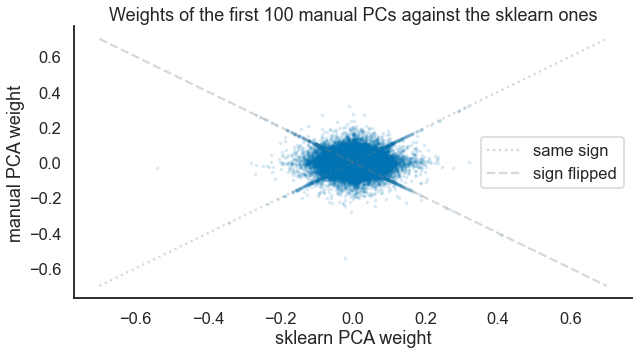

In [75]:
n_evs_to_compare = 100
    
plt.figure(figsize=(10, 5))
plt.scatter(PCs_sklearn[:,:n_evs_to_compare].flatten(), 
            PCs[:,:n_evs_to_compare].flatten(), s=5, alpha=0.1)
plt.plot([-.7,.7], [-.7,.7], ':', c='tab:gray', label='same sign', alpha=0.3)
plt.plot([-.7,.7], [.7,-.7], '--', c='tab:gray', label='sign flipped', alpha=0.3)
plt.legend()
plt.xlabel('sklearn PCA weight')
plt.ylabel('manual PCA weight')
plt.title('Weights of the first %u manual PCs against the sklearn ones' % (n_evs_to_compare))

sns.despine()

YOUR ANSWER HERE

Additional reading about the sign of PCs: https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers

## Task 3: Nonlinear dimensionality reduction with t-SNE

In this task, you will use the nonlinear dimensionality reduction technique tSNE and look at visualizations of the data set. First, run the default t-SNE and store the result in a variable you keep, as you will use it for plotting in the next tasks as well. Plot the result of default t-SNE with the original cluster colors. For this and the following tasks, use the PCs explaining 75% of the variance ```PCA_75_sklearn``` you computed above.

In [130]:
def plot_tsne(tsne_results, clusters=tasic_1k['clusters'], labels=['']):
    '''Plotting function for tsne results, creates one or multiple plots of tSNE-transformed data.
       If the clustering is the original one (default), original cluster colors will be used. Otherwise,
       colors will be a random permutation.
    
    input:
        tsne_results: (n, 2)-shaped array containing tSNE-transformed data or list of such arrays
                      (output of the fit_transform function of sklearn tSNE)
        clusters: (n,)-shaped array containing cluster labels or list of such arrays
        labels: optional, list of titles for the subplots
    '''
    
    if type(tsne_results)==list: # make sure we can do both single and multiple plots and are flexible regarding input
        num_plots = len(tsne_results)
    else:
        num_plots = 1
        tsne_results = [tsne_results]
    if type(clusters)==list:
        num_clusters = len(clusters)
        num_plots = num_plots * num_clusters
        tsne_results = tsne_results * num_clusters
    else:
        clusters = [clusters]*num_plots
    
    if len(labels)==1:
        labels = labels*num_plots
        
    n_clusters = len(np.unique(clusters))      # ensure a long enough color list even if we plot more than 
    n_colors = len(tasic_1k['clusterColors'])  # the original number of clusters
    if n_clusters > n_colors:
        n_extra_colors = n_clusters - n_colors
        colors = np.concatenate((tasic_1k['clusterColors'],tasic_1k['clusterColors'][:n_extra_colors]))    
    else:
        colors = tasic_1k['clusterColors']

    fig, ax = plt.subplots(num_plots,1,figsize=(10,num_plots*10))
    if num_plots==1:
        if not np.all(tasic_1k['clusters']==clusters[0]):
            current_colors = np.random.permutation(colors)
        else:
            current_colors = colors
        ax.scatter(tsne_results[0][:,0], tsne_results[0][:,1], s=1, color=current_colors[clusters[0]])
        ax.set_title(labels[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    else:
        for i in range(num_plots):
            if not np.all(tasic_1k['clusters']==clusters[i]):
                current_colors = np.random.permutation(colors)
            else:
                current_colors = colors
            ax[i].scatter(tsne_results[i][:,0], tsne_results[i][:,1], s=1, color=current_colors[clusters[i]])
            ax[i].set_title(labels[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_axis_off()
            
            

Run the following cells to set the random seed/random state, run tSNE and plot the results.

In [131]:
tsne_default = TSNE(random_state=1)
tsne_results = tsne_default.fit_transform(PCA_75_sklearn)
original_clusters = tasic_1k['clusters']

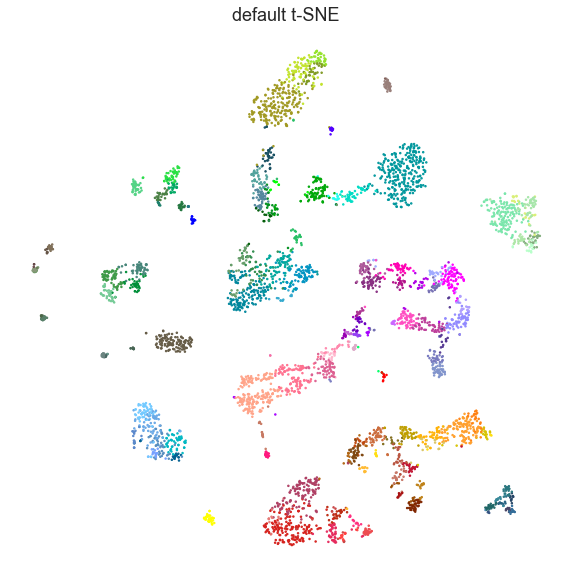

In [132]:
plot_tsne(tsne_results, original_clusters, labels=['default t-SNE'])

t-SNE has one main parameter called perplexity, which trades of local and global structure. Its default value is 30. Run the tSNE with some other perplexity values (e.g. 5, 100), plot the results next to each other and explain what you observe. In particular, compare with the PCA plot above.

In [134]:
# try different perplexities
# ---------------- INSERT CODE ----------------------
tsne_p5 = TSNE(random_state=1, perplexity=5)
tsne_p5_results = tsne_p5.fit_transform(PCA_75_sklearn)

tsne_p50 = TSNE(random_state=1, perplexity=50)
tsne_p50_results = tsne_p50.fit_transform(PCA_75_sklearn)    

tsne_p100 = TSNE(random_state=1, perplexity=100)
tsne_p100_results = tsne_p100.fit_transform(PCA_75_sklearn)

# ---------------- END CODE -------------------------


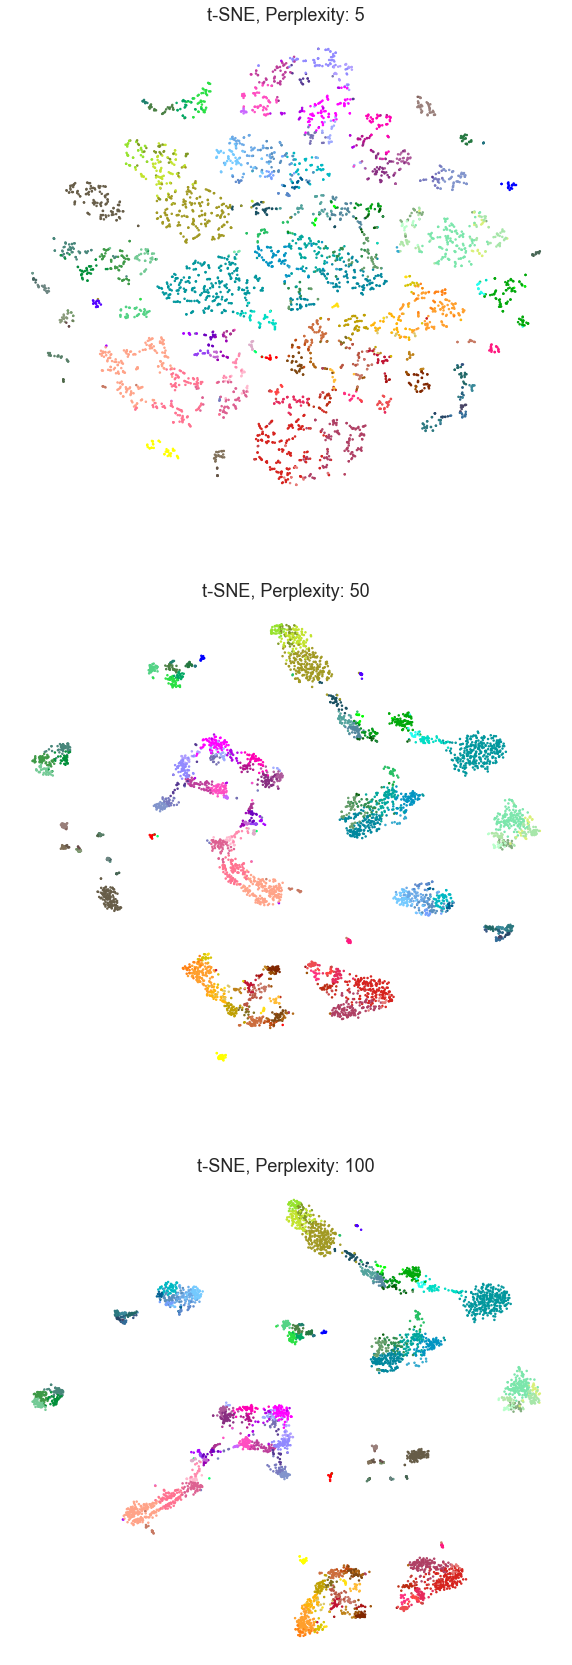

In [135]:
# plot results
# ---------------- INSERT CODE ----------------------

plot_tsne([tsne_p5_results, tsne_p50_results, tsne_p100_results], original_clusters,
          labels=['t-SNE, Perplexity: 5', 't-SNE, Perplexity: 50', 't-SNE, Perplexity: 100'])
    
# ---------------- END CODE -------------------------

YOUR ANSWER HERE

## Task 4: Cluster the data using k-Means

So far, we only visualized the data and plotted it with the original cluster labels. As a next step, we will implement k-Means as an example of a simple clustering algorithm and see how it performs on the dataset. 

Use the function KMeans provided by sklearn to perform K-Means with different numbers of clusters, for instance 5, 10, 20 and 50. Use the PCs explaining 75% of the variance ```PCA_75_sklearn``` you computed above.

In [ ]:
def run_KMeans(data, n_clusters):
    '''Function that performs K-means clustering for a given number of clusters
        input: 
            data: (cells,genes)-shaped array of log transformed cell counts
            number of clusters: int, number of clusters
        output: 
            kmeans_result: (N,)-shaped array of integers that hold the cluster assignment for each data point
    '''
    
    # ---------------- INSERT CODE ----------------------
    
    
    
    # ---------------- END CODE -------------------------   
    return kmeans_result

In [ ]:
# run kmeans
# ---------------- INSERT CODE ----------------------
    
    
    
# ---------------- END CODE -------------------------

Plot your results as cluster labels in the tSNE map and compare it to the original cluster labels. Describe your results.

In [ ]:
# plot results
# ---------------- INSERT CODE ----------------------
    
    
    
# ---------------- END CODE -------------------------

YOUR ANSWER HERE

##  Task 5: Clustering using Gaussian Mixture Models

Finally, we will implement clustering with Gaussian Mixture models ss discussed in the Bishop in Chapter 9.2.2 pg. 435-439. 

To this end, we will first generate toy data to later verify the correct implementation of the algorithm and then implement the algorithm using EM and run it on the transcriptomics data set. 

To generate the toy data, we sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_4 = \begin{bmatrix}0\\2\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

In [ ]:
def sampleData(N, means, covs, priors):
    '''Generate N samples from a Mixture of Gaussian distribution.
    
    inputs:
        N           -- number of samples
        means       -- (n_cluster,n_features)-shaped array of mean vectors
        covs        -- (n_features,n_features,n_cluster)-shaped array of covariance matrices
        prioirs     -- (n_cluster)-shaped arrays of priors / mixing coefficients
    outputs:
        data        -- (N,n_features)-shaped array of simulated data
        cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point

    '''
    
    n_components = priors.shape[0]
    n_dimensions = covs.shape[0]
    
    n_samples = (N*priors).astype(int)
    n_samples_cumsum = np.cumsum(n_samples)
   
    data = np.zeros((sum(n_samples),n_dimensions))*np.nan
    cluster_ids = np.zeros((N))*np.nan
    
        
    for i,(n_sample, n_total_samples) in enumerate(zip(n_samples, n_samples_cumsum)):
        #sample for one component and save results
        start_idx = n_total_samples-n_sample
        end_idx = n_total_samples
        data[start_idx:end_idx,:] = np.random.multivariate_normal(means[i,:], covs[:,:,i], int(n_sample))
        cluster_ids[start_idx:end_idx] = i*np.ones((int(n_sample)))
    
    return data, cluster_ids 

In [ ]:
# set up sampling
N = 1000
toy_means = np.array([[0, 0], [5, 1], [0, 4]])
toy_cov1 = np.array([[1, 0], [0, 1]])
toy_cov2 = np.array([[2, 1], [1, 2]])
toy_cov3 = np.array([[1, -.5], [-.5, 1]])
toy_covs = np.concatenate((toy_cov1[:,:,np.newaxis],
                    toy_cov2[:,:,np.newaxis],
                    toy_cov3[:,:,np.newaxis]), axis=2)
toy_priors = np.array([.3, .5, .2])   

toy_data, toy_cluster_ids_true = sampleData(N, toy_means, toy_covs, toy_priors)

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

In [ ]:
def plot_clustering(data, cluster_ids, means, title):
    '''
    Plots the (2D) data as scatter plot, with different colors and an extra symbol for the mean per cluster.
    inputs:
        data        -- (N,n_features)-shaped array of data
        cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point
        means       -- (n_cluster,n_features)-shaped array of mean vectors
        title       -- string that is added as title

    '''
    
    # ---------------- INSERT CODE ----------------------
    
    
    
    # ---------------- END CODE -------------------------  



In [ ]:
plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: Ground truth')

Implement the EM algorithm to fit a Gaussian mixture model on the PCA-transformed data. Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. 

For this task, it is important to think about a good way to initialize the means, covariances and mixing coefficients. Also, during optimization, covariance matrices can become singular. To prevent this, you can add a small constant (like $10^{-5}$) to the diagonal.

In order to speed up the computation, define a convergence criterion that stops the algorithm after convergence.

In [ ]:
def gmm(data, n_clusters, verbose=True, max_iter=1000, convergence_threshold=1e-4):
    '''Function that fits a mixture of gaussians to data.
    
        inputs:
            data          -- (n_samples, n_features)-shaped array of data points
            n_clusters    -- int, number of clusters / mixture components
            verbose       -- bool, if True, print current likelihood after each EM iteration
            max_iter      -- maximum number of EM iterations
            convergence_threshold  -- stop algorithm if change in log-lieklihood is below the treshold
    
        outputs:
            cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point
            means       -- (n_clusters, n_features)-shaped array of fit mean vectors
            covs        -- (n_features, n_features,n_cluster)-shaped array of fit covariance matrices
            priors      -- (n_cluster)-shaped arrays of fit priors / mixing coefficients
        
        '''
    
    
    # ---------------- INSERT CODE ----------------------


    ### INITIALIZATION ###
    # define means, covs and priors

    
    ### ALTERNATE BETWEEN E & M STEP ### 

        
        ### E-STEP ### 


        ### M-STEP ### 
        
        
        ### CHECK FOR CONVERGENCE/ PRINT LOG_LIKELIHOOD if VERBOSE ###
        
    
    ### ASSIGN CLUSTER LABELS ### 
    
    
    # ---------------- END CODE ------------------------- 
    
    return (cluster_ids, means, covs, priors)


Test your implementation on the toy dataset specifying the correct number of clusters and make sure the code works correctly. 

In [ ]:
toy_cluster_ids_fit, toy_means_fit, toy_covs_fit, toy_priors_fit = gmm(toy_data, 3)

Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.

In [ ]:
plot_clustering(toy_data, toy_cluster_ids_fit, toy_means_fit, 'Toy dataset: GMM clusters')
plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: True clusters')

Now apply your GMM implementation to the transcriptomics data using `n=50` clusters (as for the k-Means algorithm above). Use the PCs explaining 75% of the variance ```PCA_75_sklearn``` you computed above. Compare the result to the result of the k-Means algorithm and the original clustering labels provided by the authors. 

In [ ]:
# apply GMM to transcriptomics data
# ---------------- INSERT CODE ----------------------


# ---------------- END CODE ------------------------- 

Plot your results as cluster labels in the tSNE map and compare it to the original cluster labels and k-Means predictions. Describe your results.

In [ ]:
# plot results of GMM, k-Means and original cluster labels
# ---------------- INSERT CODE ----------------------


# ---------------- END CODE ------------------------- 